In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

sns.set(style="darkgrid")

In [2]:
dataset = "iris_data.txt"

df = pd.read_csv(dataset,delimiter=',',header=None,names=['sepal_length','sepal_width','petal_length','petal_width','specie'])

df.head()

,sepal_length,sepal_width,petal_length,petal_width,specie
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
X = df[['sepal_width','petal_length']].values # Feature set
Y = df['specie'].values # Class labels

le = preprocessing.LabelEncoder()
le.fit(np.unique(Y))
Y_encoded = le.transform(Y)

#scaler = preprocessing.StandardScaler()
#X = scaler.fit_transform(X)

x_train,x_test,y_train,y_test = train_test_split(X,Y_encoded,test_size=0.4,stratify=Y_encoded,random_state=89)

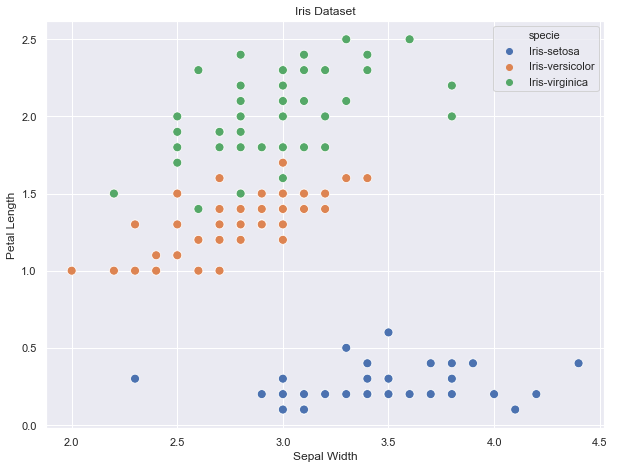

In [4]:
fig,ax = plt.subplots(figsize=(10,7.5))
ax = sns.scatterplot(x="sepal_width", y="petal_width",hue="specie", data=df,s=80)
plt.title("Iris Dataset")
plt.xlabel("Sepal Width")
plt.ylabel("Petal Length")
plt.show()

In [304]:
class Perceptron():
    def __init__(self,input_dim):
        self.weights = np.random.rand(input_dim) / 1000 # Initialize weights to random numbers
        self.delta = 0
        self.bias = 0

    def activate(self,x,activation='relu'):
        output = np.dot(x,self.weights) + self.bias # w*x + b
        if(activation == 'relu'):
            return self.relu(output)
        elif(activation == 'sigmoid'):
            return self.sigmoid(output)
        
    def sigmoid(self,x):
        return 1.0 / (1.0 + np.exp(-x))
    def relu(self,x):
        return np.maximum(0,x)

In [ ]:
class Activation():
    def apply(self,net):
        return net
    
class Relu(Activation):
    def apply(self,net):
        return np.maximum(0,x)
    def apply_derivative(self,net):
        if(output < 0):
            return 0
        else:
            return 1

In [305]:
class Layer(object):
    def __init__(self,units,input_dim=None,activation='relu'):
        self.perceptrons = []
        self.units = units
        self.input_dim = input_dim
        self.activation = activation
        self.lastActivation = []
            
    def compile(self):
        # Create perceptrons
        for i in range(0,self.units):
            self.perceptrons.append(Perceptron(self.input_dim))
            
    def activate(self,x):
        outputs = []
        for i in range(self.units):
            o = self.perceptrons[i].output(x)
            outputs.append(self.perceptrons[i].activate(o,self.activation))
        self.lastActivation = outputs
        return outputs
    
    def get_weights(self):
        weights = []
        for unit in self.perceptrons:
            weights.append(unit.weights)
        return np.array(weights)
    
    def update_weights(self,new_weights):
        new_weights = np.array(new_weights)
        for i in range(0,len(self.perceptrons)):
            self.perceptrons[i].weights = new_weights[i] 
    
    def get_gradients(self):
        gradients = []
        for i in self.lastActivation:
            grad = self.get_gradient(i)
            gradients.append(grad)
        return gradients
    
    def get_gradient(self,output):
        if(self.activation == 'relu'):
            return self.relu_grad(output)
        elif(self.activation == 'sigmoid'):
            return self.sigmoid_grad(output)
        
    def sigmoid_grad(self,output):
        return output * (1.0 - output)

    def relu_grad(self,output):
        if(output < 0):
            return 0
        else:
            return 1
    
class InputLayer(Layer):
    def __init__(self,input_dim):
        self.input_dim = input_dim
        
    def activate(self,x):
        pass

In [389]:
class Model():
    def __init__(self,lr = 0.3):
        self.layers = []
        self.layerCount = 0
        self.lr = lr
        
    def Add(self,layer):
        if(type(layer) is not Layer):
            raise Exception("Parameter should be type of Layer.")
        
        self.layers.append(layer)
        self.layerCount += 1
        
        return self
    
    def train(self,X,y,epoch = 10):
        for e in range(0,epoch):
            for row,target in zip(X,y):
                self.backPropagate(row,target)
            mse = np.mean(np.square(target - self.feedForward(row)))
            print('Epoch: #%s, MSE: %f' % (e, float(mse)))
            
    def predict(self,x):
        return self.feedForward(x)
        
    def feedForward(self,x):
        for layer in self.layers:
            x = layer.activate(x)
        return x
    
    def backPropagate(self,x,y):
        
        output_layer = self.layers[-1]
        
        output_errors = y - self.feedForward(x)
        output_delta = output_errors * output_layer.get_gradients()
        
        output_layer.error = output_errors
        output_layer.delta = output_delta
        
        for layerIndex in range(self.layerCount - 2,-1,-1):
            nextLayer = self.layers[layerIndex +  1]
            w = nextLayer.get_weights()
            d = np.array(nextLayer.delta)
            error = np.dot(w.T,d)
            delta = error * self.layers[layerIndex].get_gradients()
            self.layers[layerIndex].error = error
            self.layers[layerIndex].delta = delta
            
        z = self.layers[0].get_weights()
        k = (self.lr * x.reshape(2,1).dot(self.layers[0].delta.reshape(1,3))).T

        for p in range(self.layers[0].units):
            self.layers[0].perceptrons[p].weights += (k[p])
        for layerIndex in range(1,self.layerCount):
            for p in range(self.layers[layerIndex].units):
                self.layers[layerIndex].perceptrons[p].weights += (self.layers[layerIndex].delta[p] * self.lr * self.layers[layerIndex].lastActivation[p])

In [398]:
m = Model(lr=0.3)

m.Add(Layer(3,input_dim=2,activation='sigmoid'))
m.Add(Layer(1,input_dim=3,activation='sigmoid'))

X = np.array(([2, 9], [1, 5], [3, 6]), dtype=float)
y = np.array(([92], [86], [89]), dtype=float)
# scale units
X = X/np.amax(X, axis=0) # maximum of X array
y = y/100 # max test score is 100

m.train(X,y,100)

pred = m.predict(np.array([4,8]))
print(pred)

Epoch: #0, MSE: 0.139502
Epoch: #1, MSE: 0.127690
Epoch: #2, MSE: 0.116614
Epoch: #3, MSE: 0.106293
Epoch: #4, MSE: 0.096732
Epoch: #5, MSE: 0.087922
Epoch: #6, MSE: 0.079844
Epoch: #7, MSE: 0.072469
Epoch: #8, MSE: 0.065760
Epoch: #9, MSE: 0.059676
Epoch: #10, MSE: 0.054172
Epoch: #11, MSE: 0.049203
Epoch: #12, MSE: 0.044723
Epoch: #13, MSE: 0.040688
Epoch: #14, MSE: 0.037056
Epoch: #15, MSE: 0.033786
Epoch: #16, MSE: 0.030843
Epoch: #17, MSE: 0.028193
Epoch: #18, MSE: 0.025805
Epoch: #19, MSE: 0.023651
Epoch: #20, MSE: 0.021707
Epoch: #21, MSE: 0.019950
Epoch: #22, MSE: 0.018360
Epoch: #23, MSE: 0.016919
Epoch: #24, MSE: 0.015613
Epoch: #25, MSE: 0.014425
Epoch: #26, MSE: 0.013345
Epoch: #27, MSE: 0.012361
Epoch: #28, MSE: 0.011464
Epoch: #29, MSE: 0.010644
Epoch: #30, MSE: 0.009893
Epoch: #31, MSE: 0.009206
Epoch: #32, MSE: 0.008575
Epoch: #33, MSE: 0.007996
Epoch: #34, MSE: 0.007463
Epoch: #35, MSE: 0.006972
Epoch: #36, MSE: 0.006520
Epoch: #37, MSE: 0.006102
Epoch: #38, MSE: 0.005